In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# 1. Download data:
- For this demonstration we are just going to look at GLD --> the gold ETF

In [2]:
gld = pdr.get_data_yahoo('GLD')
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

,day,Open,High,Low,Close
Date,,,,,
2017-02-21,1,117.040001,118.000000,116.769997,117.750000
2017-02-22,2,117.860001,118.019997,117.239998,117.910004
2017-02-23,3,118.760002,119.160004,118.680000,118.940002
2017-02-24,4,119.739998,119.879997,119.250000,119.699997
2017-02-27,5,119.730003,120.400002,119.120003,119.120003


In [3]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-02-21 to 2022-02-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1259 non-null   int32  
 1   Open    1259 non-null   float64
 2   High    1259 non-null   float64
 3   Low     1259 non-null   float64
 4   Close   1259 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 54.1 KB


# 2. Add data/transform data

In [4]:
gld['9-day'] = gld['Close'].rolling(9).mean()
gld['21-day'] = gld['Close'].rolling(21).mean()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day
Date,,,,,,,
2017-03-20,20,117.309998,117.599998,117.209999,117.510002,115.621112,NaN
2017-03-21,21,117.769997,118.800003,117.760002,118.540001,116.007779,117.068096
2017-03-22,22,118.870003,119.150002,118.680000,118.830002,116.492223,117.119525
2017-03-23,23,119.150002,119.250000,118.320000,118.669998,116.931112,117.155715
2017-03-24,24,118.500000,119.209999,118.389999,118.860001,117.388890,117.151905
2017-03-27,25,119.930000,120.080002,119.269997,119.529999,117.990000,117.143810


In [5]:
# add 'signal' column
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal
Date,,,,,,,,
2017-03-21,21,117.769997,118.800003,117.760002,118.540001,116.007779,117.068096,-1
2017-03-22,22,118.870003,119.150002,118.680000,118.830002,116.492223,117.119525,-1
2017-03-23,23,119.150002,119.250000,118.320000,118.669998,116.931112,117.155715,-1
2017-03-24,24,118.500000,119.209999,118.389999,118.860001,117.388890,117.151905,1
2017-03-27,25,119.930000,120.080002,119.269997,119.529999,117.990000,117.143810,1


In [6]:
# Calculate Instantaneous returns/system returns
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2017-03-21,21,117.769997,118.800003,117.760002,118.540001,116.007779,117.068096,-1,NaN,NaN,NaN
2017-03-22,22,118.870003,119.150002,118.680000,118.830002,116.492223,117.119525,-1,0.002443,-0.002443,0.0
2017-03-23,23,119.150002,119.250000,118.320000,118.669998,116.931112,117.155715,-1,-0.001347,0.001347,0.0
2017-03-24,24,118.500000,119.209999,118.389999,118.860001,117.388890,117.151905,1,0.001600,0.001600,2.0
2017-03-27,25,119.930000,120.080002,119.269997,119.529999,117.990000,117.143810,1,0.005621,0.005621,0.0


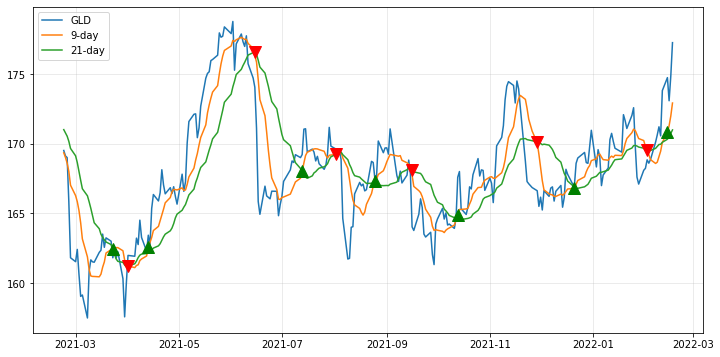

In [7]:
# plot trades
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

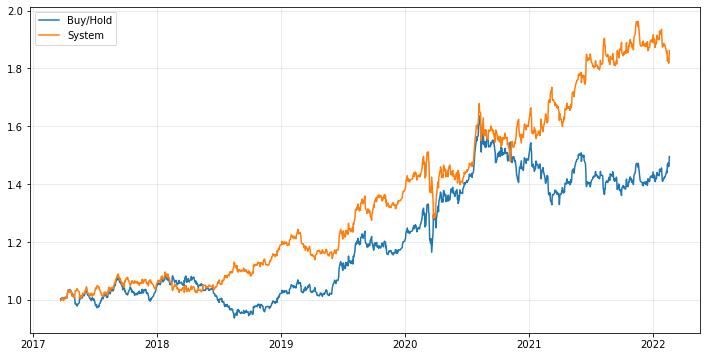

In [8]:
# comparation
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [9]:
# hold return
np.exp(gld['return']).cumprod()[-1] -1

0.4952758447024932

In [10]:
#  hold system
np.exp(gld['system_return']).cumprod()[-1] -1

0.8619269166809718